# Flood Estimation/Extrapolation

The idea of this notebook is to use the current RS detected flood and try to extrapolate it to the whole region, using a DEM. 

In [1]:
%load_ext autoreload
%autoreload 2

import icloud
import pandas as pd

import matplotlib.pyplot as plt

## iCloud Access

All the 700 processed areas are already stored in iCloud, so we will connect to it in the first hand. 

In [2]:
if 'session' not in globals():
    session = icloud.icloud_login()

## Open the Summary Table

In [3]:
summary = pd.read_parquet("../data/summary.parquet")
summary.iloc[0:10][['municipio', 'uf', 'data', 'descricao_tipologia']]#.head(10)

,municipio,uf,data,descricao_tipologia
2,Rio do Sul,SC,2017-06-01,Inundações
7,Montenegro,RS,2016-10-19,Inundações
14,Uruguaiana,RS,2017-05-31,Inundações
22,Estrela,RS,2020-07-14,Inundações
30,Montenegro,RS,2020-07-15,Inundações
36,Eldorado do Sul,RS,2016-10-20,Inundações
37,Rolante,RS,2017-01-05,Enxurradas
38,Montenegro,RS,2017-05-24,Inundações
43,Roca Sales,RS,2020-07-11,Inundações
63,Brusque,SC,2017-01-05,Enxurradas


In [49]:
place = summary.loc[37]
place

municipio                                                       Rolante
uf                                                                   RS
data                                                2017-01-05 00:00:00
ibge                                                          4316006.0
descricao_tipologia                                          Enxurradas
s3_dates               [2016-12-20, 2017-01-01, 2017-01-13, 2017-01-25]
s3_deltas                                              [-16, -4, 8, 20]
water_baseline                                                    0.061
water_areas                                 [0.03, 0.023, 0.037, 0.025]
flooded_area                                 [0.002, 0.002, 0.0, 0.002]
urban_flood                                        [0.0, 0.0, 0.0, 0.0]
status                                                           OK-Geo
Name: 37, dtype: object

## Get the Vector (AOI)

Instead of getting the vector from the urban areas shape, we are retrieving exactly the vector that has been used to create the report. These vectors are saved in `onedrive` folder.

<Axes: >

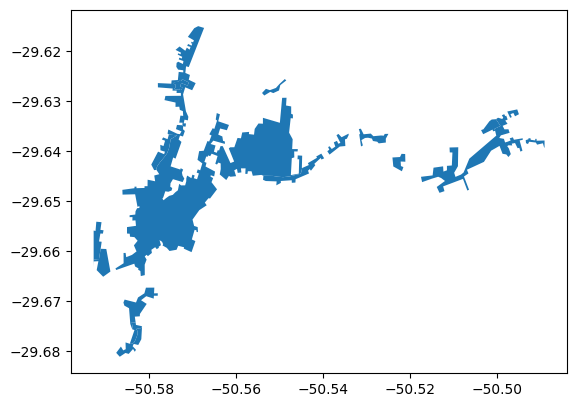

In [51]:
ICLOUD_FOLDER = 'sen1flood'

aoi = icloud.get_aoi(session.drive[ICLOUD_FOLDER]['vectors'], place, '/data/tmp')
aoi.plot()

## Get the Floods for the AOI

In [52]:
floods = icloud.get_flood(session.drive[ICLOUD_FOLDER]['rasters'], place, '/data/tmp')
floods

<xarray.Dataset>
Dimensions:                        (x: 1008, y: 772)
Coordinates:
    band                           int64 1
  * x                              (x) float64 5.394e+05 5.394e+05 ... 5.495e+05
  * y                              (y) float64 6.724e+06 6.724e+06 ... 6.716e+06
    spatial_ref                    int64 0
Data variables:
    2016-12-20T08:40:03.874451000  (y, x) bool False False False ... False False
    2017-01-01T08:40:02.380517000  (y, x) bool False False False ... False False
    2017-01-13T08:40:01.976072000  (y, x) bool False False False ... False False
    2017-01-25T08:40:01.655253000  (y, x) bool False False False ... False False
    ref                            (y, x) bool False False False ... False False

In [53]:
floods_series = floods.drop('ref').to_array(dim='layer').sum(dim=['x', 'y']).to_series()
floods_series

layer
2016-12-20T08:40:03.874451000    21
2017-01-01T08:40:02.380517000    18
2017-01-13T08:40:01.976072000     0
2017-01-25T08:40:01.655253000    24
dtype: int64

In [54]:
max_flood = floods[floods_series.idxmax()]

In [55]:
max_flood = max_flood.astype('int').rio.reproject(dst_crs='epsg:4326') #, shape=dem.shape)

In [56]:
max_flood

<xarray.DataArray '2017-01-25T08:40:01.655253000' (y: 709, x: 1058)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x            (x) float64 -50.59 -50.59 -50.59 ... -50.49 -50.49 -50.49
  * y            (y) float64 -29.61 -29.61 -29.61 ... -29.68 -29.68 -29.68
    band         int64 1
    spatial_ref  int64 0

## Load the DEM

To load the DEM for the region, we are going to use the fabdem-brazil-south project, available on github: https://github.com/cordmaur/fabdem-brazil-south

In [57]:
import pystac
from shapely.geometry import box
from utils import search_catalog
import stackstac
from tqdm.notebook import tqdm

In [58]:
# open the catalog
if not 'fabdem_catalog' in globals():
    fabdem_catalog = pystac.Catalog.from_file(href='https://github.com/cordmaur/fabdem-brazil-south/raw/main/stac_catalog/catalog.json')

    for item in tqdm(fabdem_catalog.get_all_items()):
        pass

In [59]:
# get the bounding box considering the maximum flood
bbox = box(*max_flood.rio.bounds())

items = search_catalog(fabdem_catalog, bbox.buffer(0.01))
items

[<Item id=S030W051_FABDEM_V1-2>]

In [60]:
# create a cube with the items stacked
cube = stackstac.stack(
    items=items,
    bounds_latlon=bbox.bounds
)

cube

/usr/local/lib/python3.10/dist-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-16dc41b0cc9fba53bdcdd4d86f792323' (time: 1,
                                                                band: 1,
                                                                y: 253, x: 377)>
dask.array<fetch_raster_window, shape=(1, 1, 253, 377), dtype=float64, chunksize=(1, 1, 253, 377), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time            (time) datetime64[ns] 2023-10-24T19:59:27.777048
    id              (time) <U20 'S030W051_FABDEM_V1-2'
  * band            (band) <U3 'DEM'
  * x               (x) float64 -50.59 -50.59 -50.59 ... -50.49 -50.49 -50.49
  * y               (y) float64 -29.61 -29.61 -29.61 ... -29.68 -29.68 -29.68
    file_name       <U24 'S030W051_FABDEM_V1-2.tif'
    ...              ...
    proj:bbox       object {-30.0, -29.0, -51.0, -50.0}
    title           <U6 'fabdem'
    proj:epsg       int64 4326
    proj:shape      object {3600}
    proj:geometry   object {'type': 'Polygon', 'coordinates': [[[-51.0, -30.0...
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-50.593333333333334, -29.68222...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-50.59|\n| 0.00,-0.00,-29.61|\n| 0.00, 0.00, 1.00|
    resolution:  0.0002777777777777778

In [61]:
dem = cube.mean(dim='time').squeeze().compute()


In [62]:
# dem.rio.to_raster('/data/tmp/dem.tif')

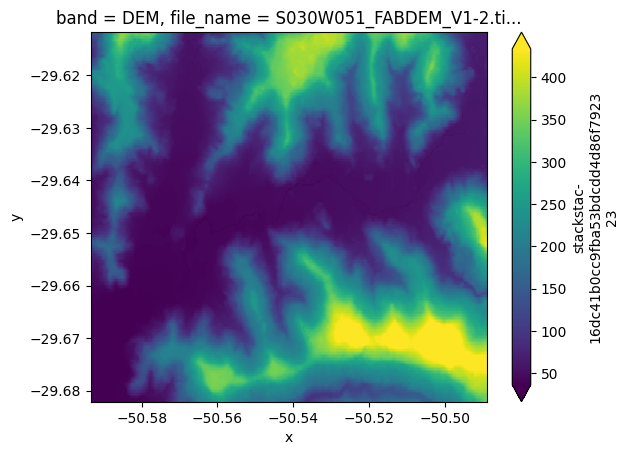

In [63]:
dem.plot.imshow(robust=True)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

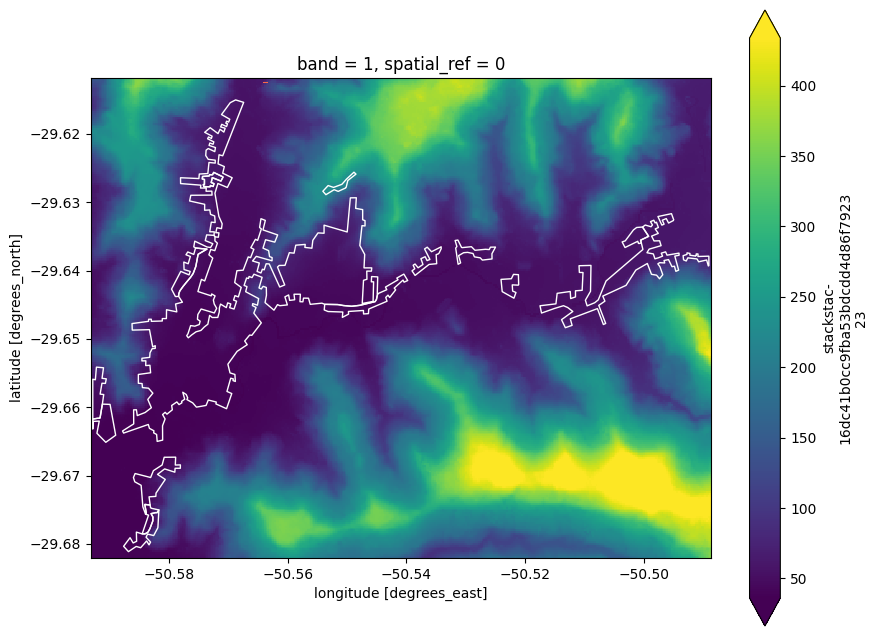

In [64]:
# plot the region
fig, ax = plt.subplots(figsize=(10, 8))
dem.plot.imshow(ax=ax, robust=True, add_colorbar=True) #type: ignore

max_flood.where(max_flood == 1).plot.imshow(ax=ax, add_colorbar=False, zorder=0, cmap='Reds')
aoi.plot(ax=ax, facecolor='none', edgecolor='white', zorder=1)


In [19]:
dem

<xarray.DataArray 'stackstac-9d84856c485329b3034aa7906b61e41d' (y: 285, x: 423)>
array([[69.34999847, 68.08999634, 67.98999786, ..., 75.04000092,
        75.30000305, 75.16999817],
       [69.76000214, 68.61000061, 68.08000183, ..., 71.5       ,
        74.34999847, 76.5       ],
       [69.48000336, 68.68000031, 68.41999817, ..., 70.38999939,
        70.58000183, 74.30999756],
       ...,
       [67.27999878, 66.69999695, 65.65000153, ..., 47.11000061,
        52.29000092, 55.29000092],
       [59.54999924, 60.20000076, 57.97999954, ..., 47.15999985,
        51.52000046, 54.70999908],
       [49.45000076, 50.31999969, 48.43000031, ..., 48.40999985,
        51.95999908, 55.25      ]])
Coordinates:
    band        <U3 'DEM'
  * x           (x) float64 -52.01 -52.01 -52.01 -52.01 ... -51.89 -51.89 -51.89
  * y           (y) float64 -29.45 -29.45 -29.45 -29.45 ... -29.53 -29.53 -29.53
    title       <U6 'fabdem'
    proj:shape  object {3600}
    proj:epsg   int64 4326
    epsg        int64 4326

In [20]:
max_flood.rio.to_raster('/data/tmp/max_flood_montenegro.tif')

## Open HAND model

In [21]:
import rioxarray as xrio

In [22]:
hand = xrio.open_rasterio('/data/anadem_hand.tif').squeeze()
xmin, ymin, xmax, ymax = dem.rio.bounds()
hand = hand.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))

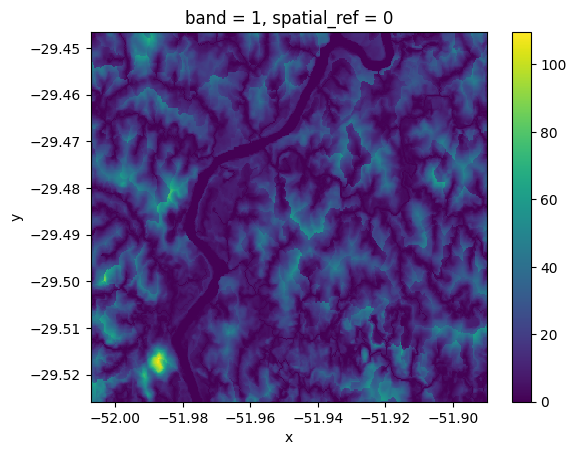

In [23]:
hand = hand.where(hand.data>=0)
hand.plot.imshow()

In [24]:
hand

<xarray.DataArray (y: 294, x: 436)>
array([[ 3.9949112,  2.873619 ,  1.6765099, ..., 30.01315  , 29.963657 ,
        32.890186 ],
       [ 5.987076 ,  2.859398 ,  1.9502563, ..., 25.349682 , 27.931026 ,
        32.964146 ],
       [ 6.554516 ,  2.5455055,  0.6695671, ..., 22.314732 , 23.666683 ,
        28.311    ],
       ...,
       [47.691536 , 49.84351  , 49.389515 , ...,  1.0025177,  3.2956467,
         7.655922 ],
       [47.165504 , 50.05781  , 47.43928  , ...,  0.7600403,  2.3834038,
         6.315258 ],
       [47.12559  , 48.32343  , 47.00436  , ...,  0.       ,  2.0645485,
         5.408581 ]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 -52.01 -52.01 -52.01 ... -51.89 -51.89 -51.89
  * y            (y) float64 -29.45 -29.45 -29.45 ... -29.53 -29.53 -29.53
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -32768.0
    scale_factor:   1.0
    add_offset:     0.0

## Open ANADEM

In [25]:
anadem = xrio.open_rasterio('/data/anadem_pitless.tif').squeeze()
anadem = anadem.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))

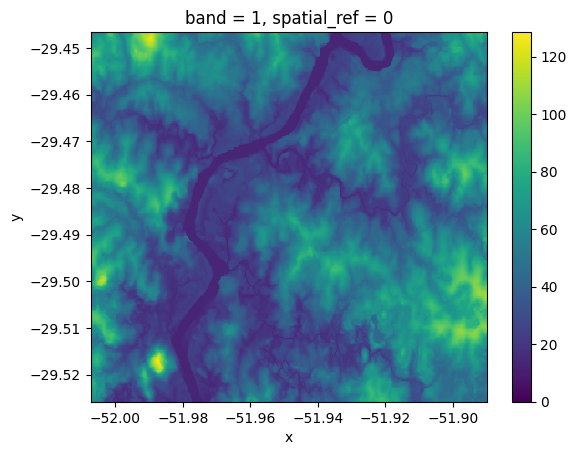

In [26]:
anadem.plot.imshow(vmin=0)

## Project DEM and FLOOD to the same shape

In [27]:
import skimage
import numpy as np

In [28]:
max_flood = max_flood.astype('int').rio.reproject(dst_crs='epsg:4326', shape=dem.shape)
hand = hand.rio.reproject(dst_crs='epsg:4326', shape=dem.shape)
anadem = anadem.rio.reproject(dst_crs='epsg:4326', shape=dem.shape)

In [43]:
def flood_areas(flood_mask, dem, threshold=25):
    """Extrapolate the flood according to the DEM of the area"""

    # first, we clean the area by removing very small regions
    flood_mask = skimage.morphology.area_opening(flood_mask, area_threshold=threshold)

    # isolate all the identified flood areas
    labels = skimage.measure.label(flood_mask)
    print(f'Number of areas to flood: {labels.max()}')

    # create a list to store the floods
    floods = []
    dem_steps = []
    for label in tqdm(range(1, labels.max()+1)):
        print(f'Processing label {label}')

        # get the flood for the corresponding label (area)
        # and set all other pixels to 0
        flood_step = labels.copy()
        flood_step[labels!=label] = 0

        # get the highest pixel within the area, but try to remove any outlier
        height = np.percentile(dem[labels==label], 90)
        # height = dem[labels==label].max()
        print(f'Height={height}')

        # create a the DEM-fences with the calculated height
        dem_step = dem.copy()
        dem_step[dem_step<=height] = 0
        dem_step[dem_step>height] = 1

        dem_steps.append(dem_step)

        # to flood-fill, we need a starting point, we can get the lowest point with the label
        xs, ys = np.where(labels==label)
        pos = dem[xs, ys].argmin()
        start = (xs[pos], ys[pos])

        # flood fill and get the extended flood for this label
        flood = skimage.morphology.flood_fill(dem_step, seed_point=start, new_value=-1)
        flood = np.where(flood==-1, 1, 0)
        floods.append(flood)

    return floods, labels, dem_steps
        

In [30]:
def flood_areas_hand(flood_mask, dem, hand, threshold=50):
    """Extrapolate the obtained flood mask according to the DEM and HAND of the area"""

    # first, we clean the area by removing very small regions
    flood_mask = skimage.morphology.area_opening(flood_mask, area_threshold=threshold)

    # isolate all the identified flood areas
    labels = skimage.measure.label(flood_mask)
    print(f'Number of areas to flood: {labels.max()}')

    # create lists to store the floods for each label and the dem region for each label
    floods = []
    dem_steps = []

    # let's loop through each label (i.e., flood region)
    for label in tqdm(range(1, labels.max()+1)):
        print(f'Processing label {label}')

        # get the flood for the corresponding label (area)
        # and set all other pixels to 0
        flood_step = labels.copy()
        flood_step[labels!=label] = 0

        # get the highest pixel within the area, but try to remove any outlier
        height = np.percentile(dem[labels==label], 95)
        # height = dem[labels==label].max()
        print(f'Height={height}')

        # create a the DEM-fences with the calculated height
        # this guarantees the flood fill will not go uphill and will not cross boundaries
        dem_step = dem.copy()
        dem_step[dem_step<=height] = 0
        dem_step[dem_step>height] = 1


        # the problem with the last assumption is that the river goes down so the farthest from the fill point
        # a bigger area will be flooded. In this case, we add a second assumption considering the HAND value
        hand_height = np.percentile(hand[labels==label], 95)
        if not np.isnan(hand_height):

            print(f'Hand height = {hand_height}')
            # dem_step[hand <= hand_height] = 0
            dem_step[hand > hand_height] = 1

            dem_steps.append(dem_step)

            # to flood-fill, we need a starting point, we can get the lowest point with the label
            xs, ys = np.where(labels==label)
            pos = dem[xs, ys].argmin()
            start = (xs[pos], ys[pos])

            # flood fill and get the extended flood for this label
            flood = skimage.morphology.flood_fill(dem_step, seed_point=start, new_value=-1)
            flood = np.where(flood==-1, 1, 0)

        else:
            print(f'No hand available')
            flood = np.where(labels == label, 1, 0)
            dem_steps.append(flood)

        floods.append(flood)

    return floods, labels, dem_steps, hand_height

In [31]:
flooded_regions, labels, dem_steps, hand_height = flood_areas_hand(max_flood.data, anadem.data, hand.data.squeeze(), threshold=10)

Number of areas to flood: 14


  0%|          | 0/14 [00:00<?, ?it/s]

Processing label 1
Height=14.0
Hand height = 0.21899986267089844
Processing label 2
Height=16.010919094085693
Hand height = 2.2019195556640625
Processing label 3
Height=19.22677536010742
Hand height = 3.335639190673828
Processing label 4
Height=20.906256866455077
Hand height = 5.410256576538084
Processing label 5
Height=18.189154624938965
Hand height = 2.4669103622436523
Processing label 6
Height=19.51253662109375
Hand height = 3.2207103729248048
Processing label 7
Height=18.42434730529785
Hand height = 2.0303073883056624
Processing label 8
Height=23.691438674926758
Hand height = 7.810222148895264
Processing label 9
Height=24.808868503570555
Hand height = 8.932151889801023
Processing label 10
Height=18.09257221221924
Hand height = 4.619571685791016
Processing label 11
Height=20.443363189697266
Hand height = 4.845272636413572
Processing label 12
Height=14.311322212219238
Hand height = 0.8593215942382812
Processing label 13
Height=22.812446308135986
Hand height = 4.491063690185545
Proces

In [32]:
# dem.rio.to_raster('/data/tmp/dem.tif')

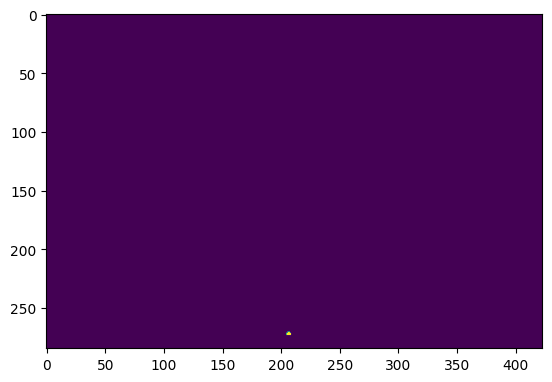

In [33]:
label = 13
plt.imshow(labels==label)

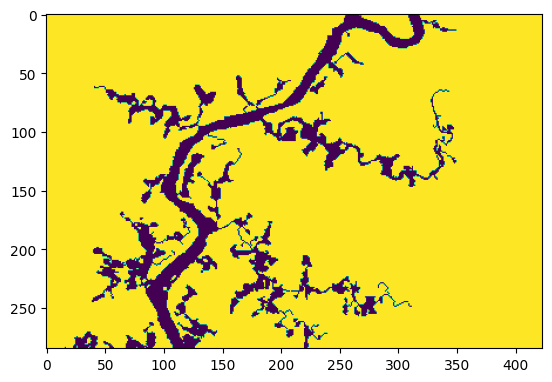

In [34]:
plt.imshow(dem_steps[label-1])

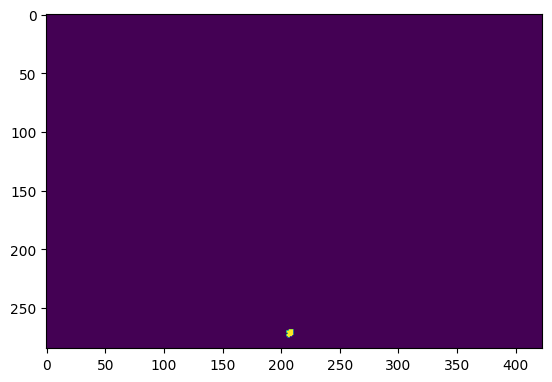

In [35]:
plt.imshow(flooded_regions[label-1])

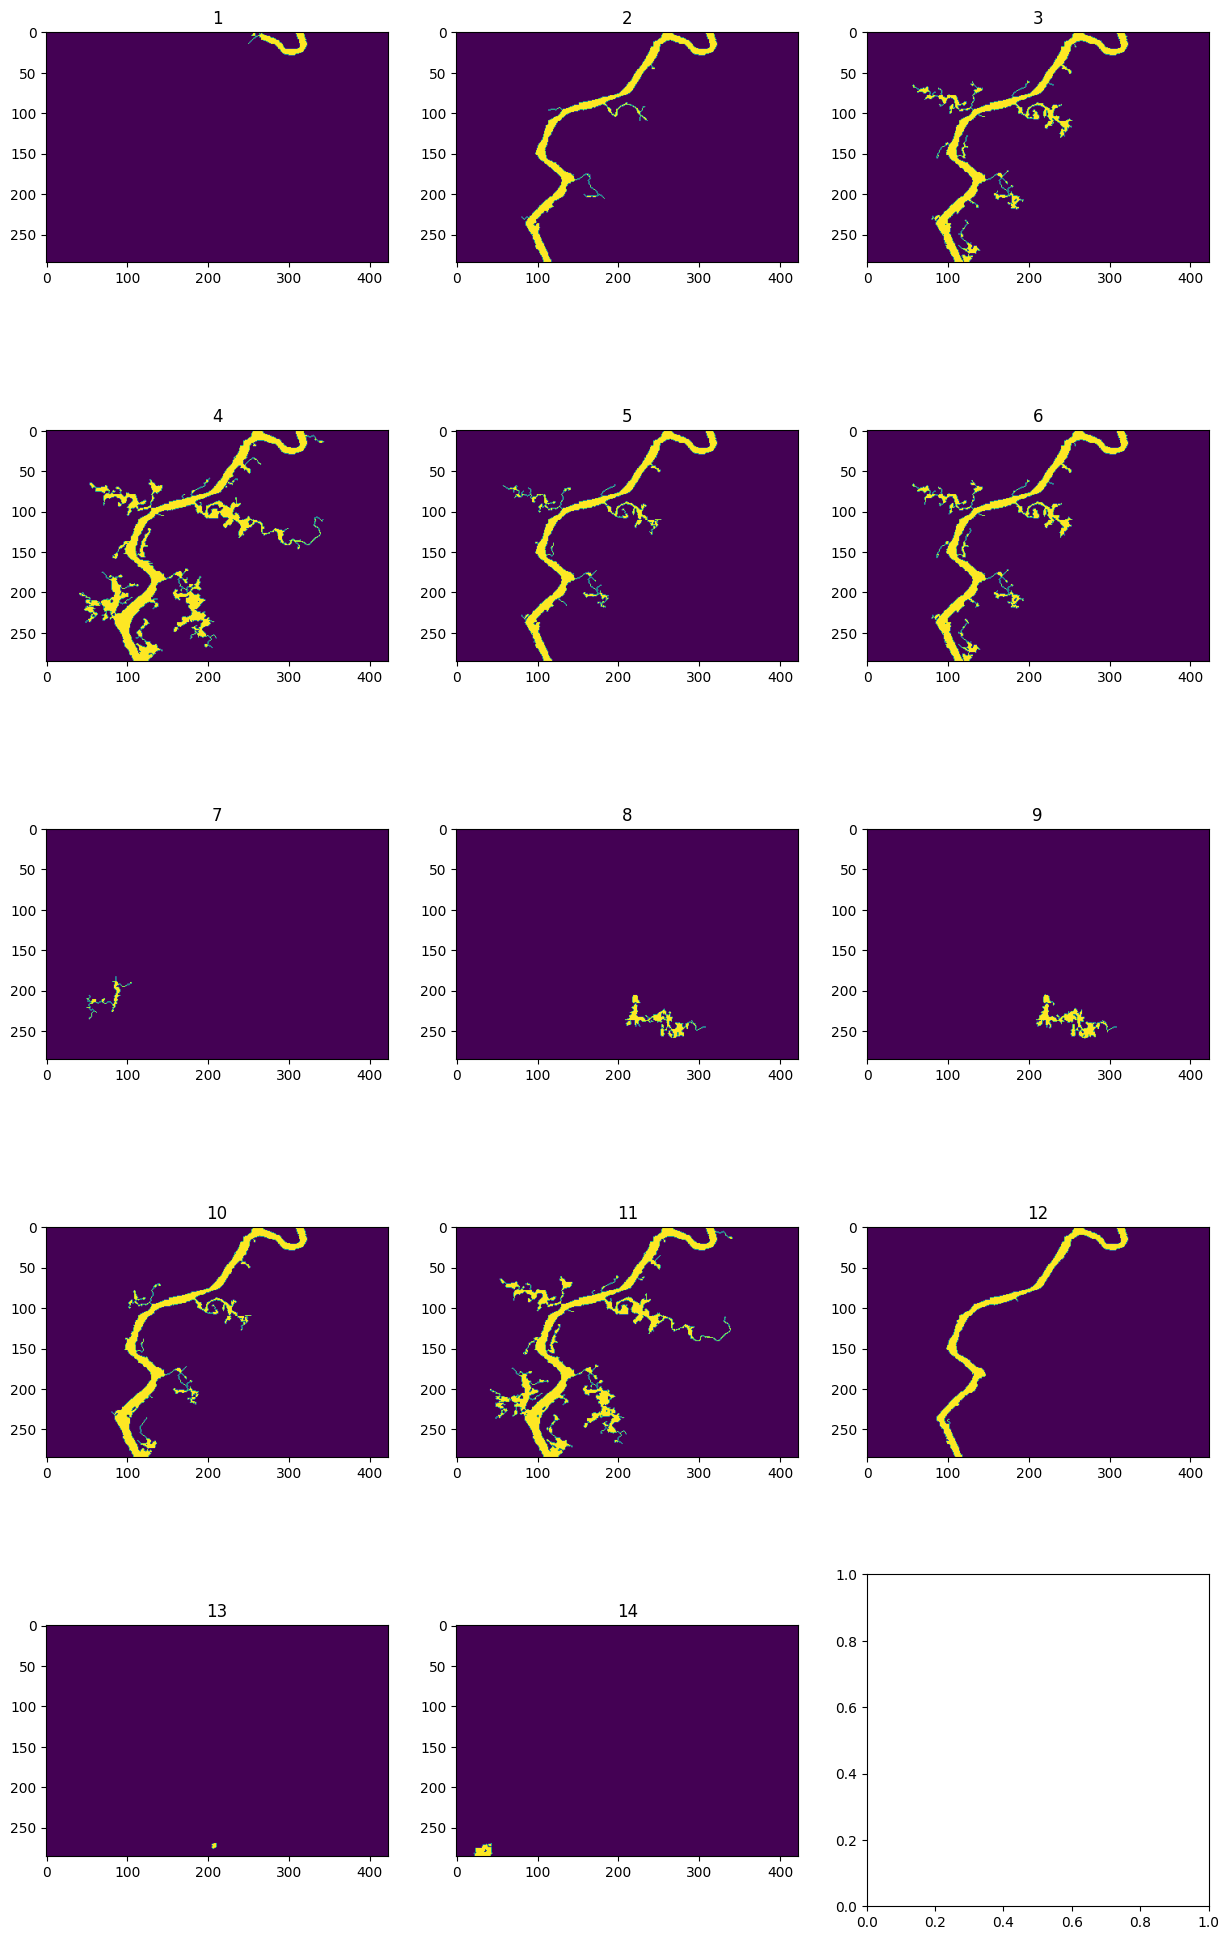

In [36]:
import math 

n = len(flooded_regions)
cols = 3
rows = math.ceil(n/cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
for i in range(n):
    ax = axs.reshape(-1)[i]
    ax.set_title(i+1)
    ax.imshow(flooded_regions[i])


In [37]:
# create final mask
# concatenate the floods into a cube
floods_cube = np.stack(flooded_regions)


In [38]:
extrapolated_flood = max_flood.copy()
extrapolated_flood.data = floods_cube.any(axis=0)

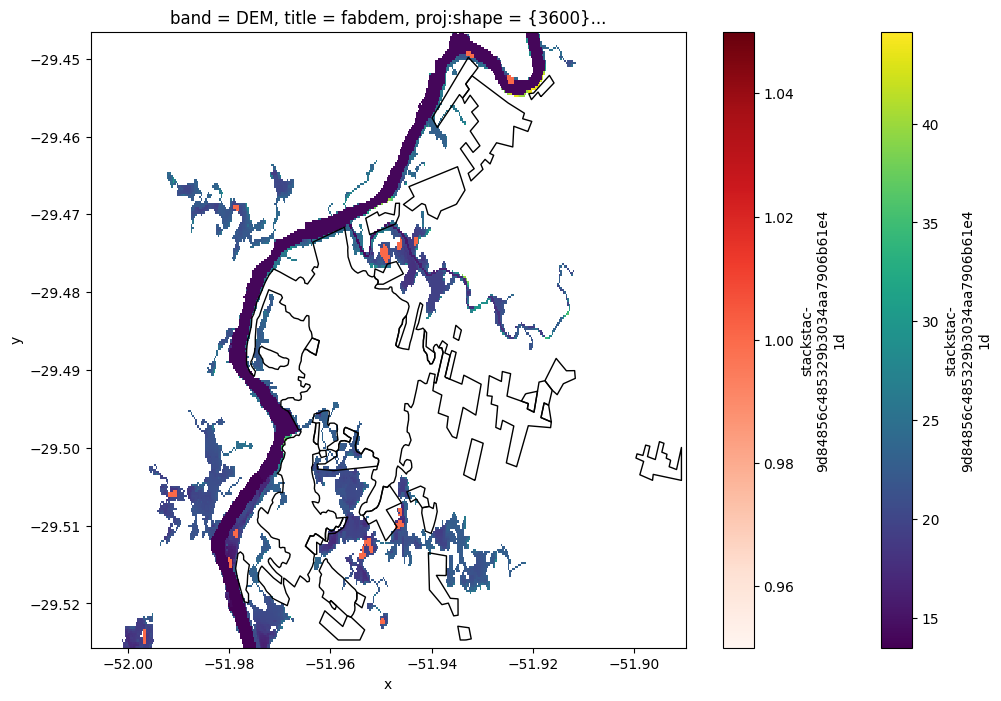

In [39]:
ax = aoi.plot(zorder=1, figsize=(12,8), facecolor='none', edgecolor='black')
dem.where(extrapolated_flood.data==1).plot.imshow(ax=ax)
# dem.where(dem < flood_height).plot(zorder=0)
labels_spatial = dem.copy()
labels_spatial.data = labels > 0

labels_spatial.where(labels_spatial.data == True).plot.imshow(ax=ax, cmap='Reds', vmax=1)


In [44]:
# Option 2: Without HAND
flooded_regions, labels, dem_steps = flood_areas(max_flood.data, anadem.data, threshold=10)

Number of areas to flood: 14


  0%|          | 0/14 [00:00<?, ?it/s]

Processing label 1
Height=14.0
Processing label 2
Height=15.759986400604248
Processing label 3
Height=19.18462219238281
Processing label 4
Height=20.764114379882812
Processing label 5
Height=18.063724517822266
Processing label 6
Height=19.393125915527342
Processing label 7
Height=17.755168914794922
Processing label 8
Height=21.63644027709961
Processing label 9
Height=22.36024971008301
Processing label 10
Height=17.987197875976562
Processing label 11
Height=20.03740997314453
Processing label 12
Height=14.049631118774414
Processing label 13
Height=22.269595527648924
Processing label 14
Height=22.945754432678225


In [45]:
# create final mask
# concatenate the floods into a cube
floods_cube = np.stack(flooded_regions)

extrapolated_flood = max_flood.copy()
extrapolated_flood.data = floods_cube.any(axis=0)

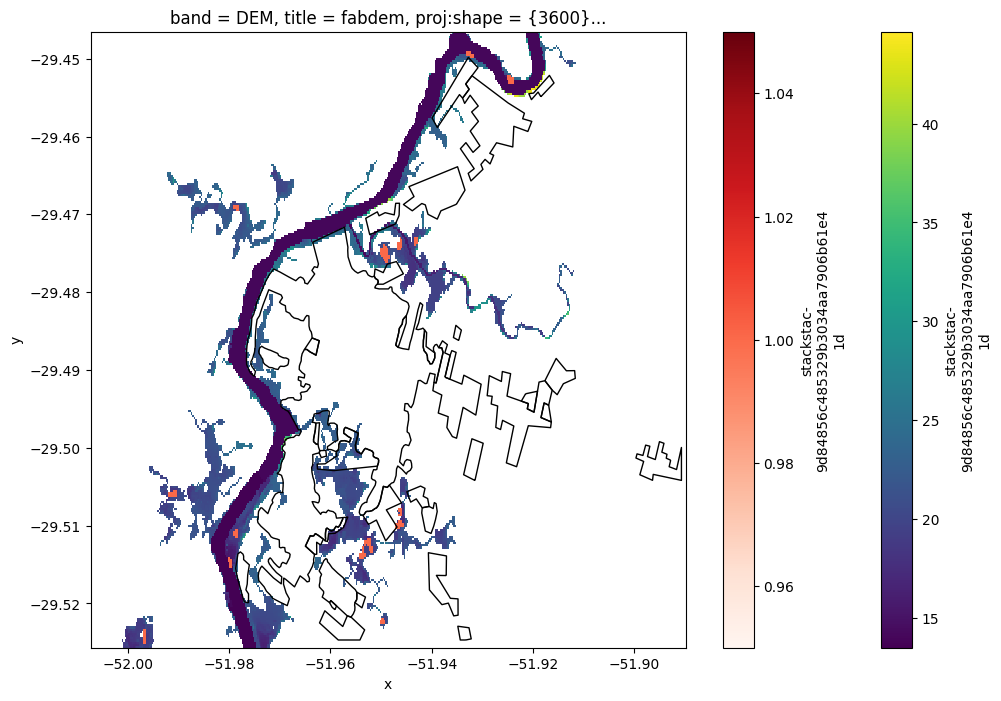

In [46]:
ax = aoi.plot(zorder=1, figsize=(12,8), facecolor='none', edgecolor='black')
dem.where(extrapolated_flood.data==1).plot.imshow(ax=ax)
# dem.where(dem < flood_height).plot(zorder=0)
labels_spatial = dem.copy()
labels_spatial.data = labels > 0

labels_spatial.where(labels_spatial.data == True).plot.imshow(ax=ax, cmap='Reds', vmax=1)


In [319]:
dem.where(extrapolated_flood.data==1).rio.to_raster('/data/tmp/extrapolated_flood.tif')


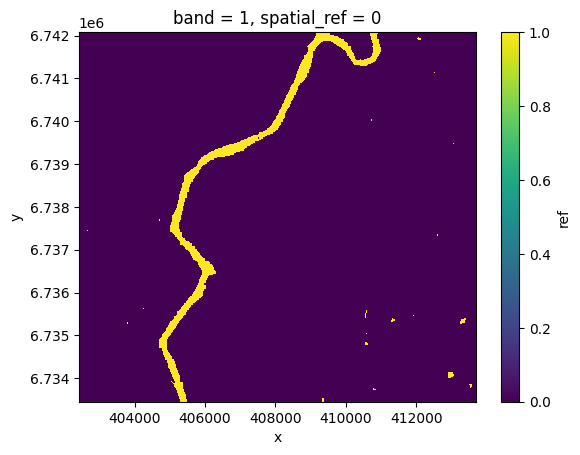

In [48]:
floods['ref'].plot.imshow()

In [141]:
flood_regions_stack = np.stack(flooded_regions)

In [142]:
flood_regions_stack.sum(axis=(1, 2))

array([320145, 322211, 321758, 320320, 321940, 321014, 319009, 321841,
       314249, 318542, 319495, 320563, 317213, 312543, 319196, 312014,
       307220, 312463, 302139, 319624, 301433])

In [63]:
flood_regions_stack.shape

(59, 469, 694)

In [64]:
len(flooded_regions)

59

In [82]:
np.percentile?

Signature:      
np.percentile(
    a,
    q,
    axis=None,
    out=None,
    overwrite_input=False,
    method='linear',
    keepdims=False,
    *,
    interpolation=None,
)
Call signature:  np.percentile(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function percentile at 0x7f09ac24f490>
File:            /usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py
Docstring:      
Compute the q-th percentile of the data along the specified axis.

Returns the q-th percentile(s) of the array elements.

Parameters
----------
a : array_like of real numbers
    Input array or object that can be converted to an array.
q : array_like of float
    Percentage or sequence of percentages for the percentiles to compute.
    Values must be between 0 and 100 inclusive.
axis : {int, tuple of int, None}, optional
    Axis or axes along which the percentiles are computed. The
    default is to compute the percentile(s) along a flattened
    version of the array.
